In [19]:
!pip install langchain-core langchain langgraph langchain-community langchain-openai pypdf langchainhub chromadb pypdf ipython

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from google.colab import userdata
api_key = userdata.get("OPENAI")

pdfs = [
    "../docs/us_states_info.pdf",
    "../docs/canada_provinces_info.pdf",
]

docs = [PyPDFLoader(pdf).load() for pdf in pdfs]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)
docs_splits = text_splitter.split_documents(docs_list)
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=docs_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(api_key=api_key),
)
retriever = vectorstore.as_retriever()

In [4]:
# Retrival grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

class GradeDocument(BaseModel):
  binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")


# LLM with function call
llm = ChatOpenAI(api_key=api_key, model="gpt-4", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocument)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrival_grader = grade_prompt | structured_llm_grader



In [5]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

rag_prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(api_key=api_key, model="gpt-4", temperature=0)

rag_chain = rag_prompt | llm | StrOutputParser()

In [6]:
# Hallucination Grader

class HallucinationGrade(BaseModel):
  binary_score: str = Field(description="Model hallucinated in answering the question, 'yes' or 'no'")

# LLM with function call
llm = ChatOpenAI(api_key=api_key, model="gpt-4", temperature=0)
structured_llm_grader = llm.with_structured_output(HallucinationGrade)
system = """You are assessing the generation based on the facts provided in the documents. \n
         Assess the generated answer. If the answer is grounded in the facts given in the documents say 'No', otherwise say 'Yes'
        """
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved documents: \n\n {documents} \n\n generated answer: {generation}"),
    ])

hallucination_grader = hallucination_prompt | structured_llm_grader

In [7]:
# Answer Grader

class AnswerGrade(BaseModel):
  binary_score: str = Field(description="Model answer is correct, 'yes' or 'no'")

# LLM with function call
llm = ChatOpenAI(api_key=api_key, model="gpt-4", temperature=0)
structured_llm_grader = llm.with_structured_output(AnswerGrade)
system = """You are assessing the generated answer. \n
         Assess the generated answer. If the answer addresses the question correctly say 'Yes', otherwise say 'No'.
        """
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "generated answer: {generation} \n\n question: {question}"),
    ])

answer_grader = answer_prompt | structured_llm_grader

In [8]:
def retrive_docs(state):
  question = state["question"]
  docs = retriever.get_relevant_documents(question)
  print("Retriving documents")
  return {'docs': docs, 'question': question}

In [9]:
def grade_documents(state):
  question = state["question"]
  docs = state["docs"]
  generation = state["generation"]
  filtered_docs = []
  for doc in docs:
    grade = retrival_grader.invoke({"question": question, "document": doc})
    if grade.binary_score == "yes":
      print("Doc is relevant, adding to filtered docs list")
      filtered_docs.append(doc)
    else:
      print("Doc is not relevant, going to the next one")
      pass
  return {'docs': filtered_docs, 'question': question}

In [10]:
def generate(state):
  question = state["question"]
  docs = state["docs"]
  print("Generating answer")
  generation = rag_chain.invoke({"question": question, "context": docs})
  return {'generation': generation, 'question': question}

In [11]:
def decide_to_generate(state):
  question = state["question"]
  filtered_docs = state["docs"]
  if not filtered_docs:
    print("No relevant doc")
    return 'not_useful'
  else:
    return 'generate'

In [12]:
def grade_generation_v_documents_and_question(state):
  question = state["question"]
  docs = state["docs"]
  generation = state["generation"]
  hall_grade = hallucination_grader.invoke({"documents": docs, "generation": generation})
  if hall_grade.binary_score == "No":
    answer_grade = answer_grader.invoke({"generation": generation, "question": question})
    if answer_grade.binary_score == "Yes":
      return 'useful'
    else:
      return 'not_useful'
  else:
    return 'not_supported'

# Graph

<center><figure><img src="../imgs/self-rag.png" alt="drawing" width="1100"/><figcaption>Fig. 1: Graph diagram</figcaption></figure></center>

In [13]:
from typing import List, TypedDict

class GraphSate(TypedDict):
  question: str
  docs: List[str]
  generation: str



In [14]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphSate)
workflow.add_node('retrive', retrive_docs)
workflow.add_node('generate', generate)
workflow.add_node('grade_documents', grade_documents)

workflow.add_edge(START, 'retrive')
workflow.add_edge('retrive', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        "not_useful": END,
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    'generate',
    grade_generation_v_documents_and_question,
    {
        "not_supported": "generate",
        "not_useful": END,
        "useful": END,
    },
)

app = workflow.compile()

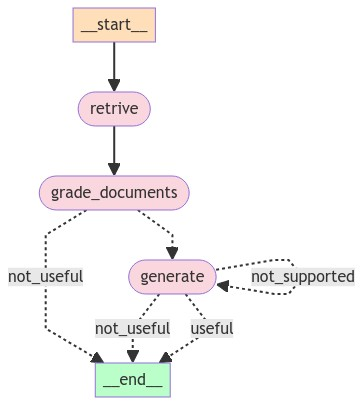

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Output

Try with non-relevant question to our index.

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "What is agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint(f"value: {value}")
    pprint("\n---\n")
# Final generation
response = value.get('generation')
if response is None:
    print("Couldn't generate a uselful answer")
else:
    pprint(response)

Retriving documents
"Node 'retrive':"
'\n---\n'
Doc is not relevant, going to the next one
Doc is not relevant, going to the next one
Doc is not relevant, going to the next one
Doc is not relevant, going to the next one
No relevant doc
"Node 'grade_documents':"
'\n---\n'
Couldn't generate a uselful answer


Try with a relevant question to our index

In [ ]:
# Run
inputs = {"question": "What is life in Ontorio like??"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint(f"value: {value}")
    pprint("\n---\n")
# Final generation
response = value.get('generation')
if response is None:
    print("Couldn't generate a uselful answer")
else:
    pprint(response)

Retriving documents
"Node 'retrive':"
'\n---\n'
Doc is relevant, adding to filtered docs list
Doc is not relevant, going to the next one
Doc is not relevant, going to the next one
Doc is not relevant, going to the next one
"Node 'grade_documents':"
'\n---\n'
Generating answer
"Node 'generate':"
'\n---\n'
('Life in Ontario, Canada is characterized by a humid continental climate with '
 'hot summers and cold winters. It has a diverse cultural heritage with '
 'influences from around the world, and is known for arts, music, and sports. '
 'The cost of living is high, particularly in Toronto.')
